In [29]:

import os
os.system('pip3 install Seaborn')
os.system('pip3 install xgboost')

0

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# Load in all the data
samplesubmission = pd.read_csv('data/samplesubmission.csv')
solution_template = pd.read_csv('data/solution_template.csv')
training = pd.read_csv('data/training_v2.csv')
unlabeled = pd.read_csv('data/unlabeled.csv')
wids = pd.read_csv('data/WiDS_Datathon_2020_Dictionary.csv')

# CSV files must be in folder called 'data' in the same directory as the notebook 

In [31]:
# Find all the categorical features and set them to their appropriate type

num_unique_values = training.nunique().sort_values(ascending=False)
display(num_unique_values)
# After manually inspecting it seems that hospital_admit_source is the last categorical feature
# So we'll convert all columns with less unique values to a categorical feature as well
categorical_features = num_unique_values[num_unique_values <= 15].index
training_typed = training.astype(dict(zip(categorical_features, ['category'] * len(categorical_features))))

encounter_id             91713
patient_id               91713
bmi                      34888
urineoutput_apache       24772
pre_icu_los_days          9757
                         ...  
gcs_unable_apache            2
elective_surgery             2
gender                       2
apache_post_operative        2
readmission_status           1
Length: 186, dtype: int64

In [32]:
# Show the percentage of non missing values for each feature
missing = (training_typed.notna().sum() / len(training)) * 100

# Looking at the data there is a big gap in data availability between wbc_apache and urineoutput_apache, namely 75% and then 46%
# To make analysis easier we'll only consider features with more than 50% data availability
chosen_features = list(missing[missing > 50].index)

In [33]:
df_training = training_typed[chosen_features].fillna(training_typed[chosen_features].mean(numeric_only=True))
df_training = df_training.loc[(df_training['temp_apache'] >= 15) & (df_training['temp_apache'] <= 45) & (df_training['h1_temp_min'] >= 15) & (df_training['h1_temp_max'] <= 45)]
# df_training.select_dtypes(include=['category'])
# df_final = pd.get_dummies(df_training)

In [34]:
test_size = 0.2 # proportion for train versus test+val split
val_size = 0.5 # proportion for test versus val split
random_state = 42  # random state is used to set a seed for randomness, which is only relevant for reproducibility purposes

In [35]:
from sklearn.model_selection import train_test_split

X = df_training.copy().drop(['hospital_death', 'patient_id', 'encounter_id', 'hospital_id', 'icu_id', # drop identifiers
                    'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', # drop high correlation vitals
                    'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min', 'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min', 'h1_sysbp_noninvasive_max', 'h1_sysbp_noninvasive_min', # drop high correlation vitals
                    'height','weight','d1_bun_min','d1_bun_max','d1_creatinine_min','d1_creatinine_max','d1_glucose_max','d1_hemaglobin_max','d1_hemaglobin_min','d1_hematocrit_max','d1_hematocrit_min','d1_sodium_max','d1_sodium_min','d1_wbc_max','d1_wbc_min', # drop correlated features
                    'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob'], # drop APACHE scores
                   axis=1)
y = df_training['hospital_death'].copy()
y_apache = df_training['apache_4a_hospital_death_prob'].copy()

X = pd.get_dummies(X, drop_first=True)

# convert bool cols to binary
bool_cols = X.select_dtypes(include=['bool']).columns
X[bool_cols] = X[bool_cols].astype(int)

# split the dataset into train and test+validation set
(X_train, X_test,
 y_train, y_test,
 y_apache_train, y_apache_test
) = train_test_split(X, y, y_apache, test_size=test_size, random_state=random_state)

# split the test set into test + validation set
(X_val, X_test,
 y_val, y_test,
 y_apache_val, y_apache_test,
) = train_test_split(X_test, y_test, y_apache_test, test_size=val_size, random_state=random_state)

In [36]:
# Removing sensitive features from the training data
sensitive_features = ['ethnicity_Asian', 'ethnicity_Caucasian', 'ethnicity_Hispanic', 'ethnicity_Native American', 'ethnicity_Other/Unknown',
                      'gender_M', 'age']
X_train.drop(sensitive_features, axis=1);

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import recall_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest, f_classif

k_best_selector = SelectKBest(score_func=f_classif, k=50)
k_best_selector.fit(X_train, y_train)
selected_feature_indices = k_best_selector.get_support(indices=True)
selected_features = X_train.columns[selected_feature_indices]
sensitive_features = ['ethnicity_Asian', 'ethnicity_Caucasian', 'ethnicity_Hispanic', 'ethnicity_Native American', 'ethnicity_Other/Unknown',
                      'gender_M', 'age']

all_features = sensitive_features + selected_features.tolist()
all_features = list(set(all_features))

X_train = X_train.loc[:, all_features]
X_test = X_test.loc[:, all_features]

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
print(f"RFC Recall: {recall_score(y_test, rfc.predict(X_test))}")

lg = LogisticRegression(solver='liblinear')
lg.fit(X_train, y_train)
print(f"LG Recall: {recall_score(y_test, lg.predict(X_test))}")

xgb = XGBClassifier()
xgb.fit(X_train, y_train)
print(f"XGB Recall: {recall_score(y_test, xgb.predict(X_test))}")

y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred))

RFC Recall: 0.20606826801517067
LG Recall: 0.20986093552465235
XGB Recall: 0.2996207332490518
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      8381
           1       0.71      0.21      0.32       791

    accuracy                           0.92      9172
   macro avg       0.82      0.60      0.64      9172
weighted avg       0.91      0.92      0.90      9172



Recall, F1 and Area Under ROC for Ethnic Groups

In [38]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
# Define a dictionary to map ethnicity names to their corresponding boolean columns
ethnicity_columns = {
    'Asian': 'ethnicity_Asian',
    'Caucasian': 'ethnicity_Caucasian',
    'Hispanic': 'ethnicity_Hispanic',
    'Native American': 'ethnicity_Native American',
    'Other/Unknown': 'ethnicity_Other/Unknown'
}

# Loop through each ethnicity and evaluate accuracy
for ethnicity, column_name in ethnicity_columns.items():
    # Filter test data based on the ethnicity column
    mask = X_test[column_name] == 1  # Filter for rows where the ethnicity column is 1 (True)
    X_test_ethnicity = X_test[mask]
    y_test_ethnicity = y_test[mask]
    
    #Calculate Recall, F1 and Area under ROC curve for each model
    rfc_recall = recall_score(y_test_ethnicity, rfc.predict(X_test_ethnicity))
    lg_recall = recall_score(y_test_ethnicity, lg.predict(X_test_ethnicity))
    xgb_recall = recall_score(y_test_ethnicity, xgb.predict(X_test_ethnicity))

    print(f"Ethnicity: {ethnicity}")
    # Uncomment to reveal values
    print(f"RFC Recall: {round(rfc_recall, 3)}")
    print(f"LG Recall: {round(lg_recall, 3)}")
    print(f"XGB Recall: {round(xgb_recall, 3)}")

    

    

Ethnicity: Asian
RFC Recall: 0.4
LG Recall: 0.4
XGB Recall: 0.5
Ethnicity: Caucasian
RFC Recall: 0.209
LG Recall: 0.207
XGB Recall: 0.302
Ethnicity: Hispanic
RFC Recall: 0.156
LG Recall: 0.178
XGB Recall: 0.222
Ethnicity: Native American
RFC Recall: 0.333
LG Recall: 0.333
XGB Recall: 0.444
Ethnicity: Other/Unknown
RFC Recall: 0.154
LG Recall: 0.154
XGB Recall: 0.308


In [39]:
for ethnicity, column_name in ethnicity_columns.items():
    rfc_f1 = f1_score(y_test_ethnicity, rfc.predict(X_test_ethnicity))
    lg_f1 = f1_score(y_test_ethnicity, lg.predict(X_test_ethnicity))
    xgb_f1 = f1_score(y_test_ethnicity, xgb.predict(X_test_ethnicity))

    print(f"Ethnicity: {ethnicity}")
    print(f"RFC F1 score: {round(rfc_f1, 3)}")
    print(f"LG F1 score: {round(lg_f1, 3)}")
    print(f"XGB F1 score: {round(xgb_f1, 3)}")

Ethnicity: Asian
RFC F1 score: 0.245
LG F1 score: 0.222
XGB F1 score: 0.407
Ethnicity: Caucasian
RFC F1 score: 0.245
LG F1 score: 0.222
XGB F1 score: 0.407
Ethnicity: Hispanic
RFC F1 score: 0.245
LG F1 score: 0.222
XGB F1 score: 0.407
Ethnicity: Native American
RFC F1 score: 0.245
LG F1 score: 0.222
XGB F1 score: 0.407
Ethnicity: Other/Unknown
RFC F1 score: 0.245
LG F1 score: 0.222
XGB F1 score: 0.407


In [40]:
for ethnicity, column_name in ethnicity_columns.items(): 
    rfc_auc = roc_auc_score(y_test_ethnicity, rfc.predict(X_test_ethnicity))
    lg_auc = roc_auc_score(y_test_ethnicity, lg.predict(X_test_ethnicity))
    xgb_auc = roc_auc_score(y_test_ethnicity, xgb.predict(X_test_ethnicity))
    
    print(f"Ethnicity: {ethnicity}")
    print(f"RFC Area under ROC: {round(rfc_auc, 3)}")
    print(f"LG Area under ROC: {round(lg_auc, 3)}")
    print(f"XGB Area under ROC: {round(xgb_auc, 3)}")

Ethnicity: Asian
RFC Area under ROC: 0.572
LG Area under ROC: 0.566
XGB Area under ROC: 0.644
Ethnicity: Caucasian
RFC Area under ROC: 0.572
LG Area under ROC: 0.566
XGB Area under ROC: 0.644
Ethnicity: Hispanic
RFC Area under ROC: 0.572
LG Area under ROC: 0.566
XGB Area under ROC: 0.644
Ethnicity: Native American
RFC Area under ROC: 0.572
LG Area under ROC: 0.566
XGB Area under ROC: 0.644
Ethnicity: Other/Unknown
RFC Area under ROC: 0.572
LG Area under ROC: 0.566
XGB Area under ROC: 0.644


Recall, F1 and Area under ROC for Males and Females

In [41]:
filter_m = X_test['gender_M'] == 1

rfc_recall = recall_score(y_test[filter_m], rfc.predict(X_test[filter_m]))
lg_recall = recall_score(y_test[filter_m], lg.predict(X_test[filter_m]))
xgb_recall = recall_score(y_test[filter_m], xgb.predict(X_test[filter_m]))

print("RFC Recall for Male:", round(rfc_recall, 3))
print("LG Recall for Male:", round(lg_recall, 3))
print("XGB Recall for Male:", round(xgb_recall, 3))

rfc_recall = recall_score(y_test[~filter_m], rfc.predict(X_test[~filter_m]))
lg_recall = recall_score(y_test[~filter_m], lg.predict(X_test[~filter_m]))
xgb_recall = recall_score(y_test[~filter_m], xgb.predict(X_test[~filter_m]))

print("RFC Recall for female:", round(rfc_recall,3))
print("LG Recall for female:", round(lg_recall, 3))
print("XGB Recall for female:", round(xgb_recall, 3))

RFC Recall for Male: 0.203
LG Recall for Male: 0.205
XGB Recall for Male: 0.306
RFC Recall for female: 0.21
LG Recall for female: 0.216
XGB Recall for female: 0.291


In [42]:
filter_m = X_test['gender_M'] == 1

rfc_f1 = f1_score(y_test[filter_m], rfc.predict(X_test[filter_m]))
lg_f1 = f1_score(y_test[filter_m], lg.predict(X_test[filter_m]))
xgb_f1 = f1_score(y_test[filter_m], xgb.predict(X_test[filter_m]))

print("RFC f1 for Male:", round(rfc_f1, 3))
print("LG f1 for Male:", round(lg_f1, 3))
print("XGB f1 for Male:", round(xgb_f1, 3))

rfc_f1 = f1_score(y_test[~filter_m], rfc.predict(X_test[~filter_m]))
lg_f1 = f1_score(y_test[~filter_m], lg.predict(X_test[~filter_m]))
xgb_f1 = f1_score(y_test[~filter_m], xgb.predict(X_test[~filter_m]))

print("RFC f1 for female:", round(rfc_f1, 3))
print("LG f1 for female:", round(lg_f1, 3))
print("XGB f1 for female:", round(xgb_f1, 3))

RFC f1 for Male: 0.317
LG f1 for Male: 0.308
XGB f1 for Male: 0.407
RFC f1 for female: 0.324
LG f1 for female: 0.321
XGB f1 for female: 0.389


In [43]:
filter_m = X_test['gender_M'] == 1

rfc_roc = roc_auc_score(y_test[filter_m], rfc.predict(X_test[filter_m]))
lg_roc = roc_auc_score(y_test[filter_m], lg.predict(X_test[filter_m]))
xgb_roc = roc_auc_score(y_test[filter_m], xgb.predict(X_test[filter_m]))

print("RFC ROCAUC for Male:", round(rfc_roc, 3))
print("LG ROCAUC for Male:", round(lg_roc, 3))
print("XGB ROCAUC for Male:", round(xgb_roc, 3))

rfc_roc = roc_auc_score(y_test[~filter_m], rfc.predict(X_test[~filter_m]))
lg_roc = roc_auc_score(y_test[~filter_m], lg.predict(X_test[~filter_m]))
xgb_roc = roc_auc_score(y_test[~filter_m], xgb.predict(X_test[~filter_m]))

print("RFC ROCAUC for female:", round(rfc_roc, 3))
print("LG ROCAUC for female:", round(lg_roc, 3))
print("XGB ROCAUC for female:", round(xgb_roc, 3))

RFC ROCAUC for Male: 0.598
LG ROCAUC for Male: 0.597
XGB ROCAUC for Male: 0.644
RFC ROCAUC for female: 0.601
LG ROCAUC for female: 0.602
XGB ROCAUC for female: 0.636


CONSTRAINED LEARNING OF BEST MODEL

In [44]:
#XGB performs best overall so far
import xgboost as xgb

# Calculate class weights for XGBoost
class_weights_xgb = len(df_training[df_training['hospital_death'] == 0]) / len(df_training[df_training['hospital_death'] == 1])

# Define XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'scale_pos_weight': class_weights_xgb,  # Set scale_pos_weight to the calculated class weight
}

# Convert data to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)

# Train XGBoost model
xgb_weighed = xgb.train(params, dtrain)
dtest = xgb.DMatrix(X_test)
y_pred_proba = xgb_weighed.predict(dtest)


TESTING OF REWEIGHED MODEL

In [45]:
from sklearn.metrics import precision_score, recall_score

# Make predictions on the training set
y_train_pred_proba = xgb_weighed.predict(dtrain)
y_train_pred = (y_train_pred_proba > 0.65).astype(int)  # Assuming threshold of 0.5

# Compute precision and recall
precision = precision_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)

print("Precision on Training Set:", precision)
print("Recall on Training Set:", recall)

Precision on Training Set: 0.403772202893243
Recall on Training Set: 0.6969026548672567


Metrics for each sensitive group

In [46]:
y_pred = (y_pred_proba > 0.5).astype(int)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Precision on Training Set:", precision)
print("Recall on Training Set:", recall)

Precision on Training Set: 0.26834659593280286
Recall on Training Set: 0.7673830594184576


In [47]:
y_apache_test_bin = (y_apache_test > 0.5).astype(int)
apache_recall = recall_score(y_test, y_apache_test_bin)
apache_roc = roc_auc_score(y_test, y_apache_test_bin)
apache_precision = precision_score(y_test, y_apache_test_bin)

print("Apache recall:", apache_recall)
print("Apache Area under ROC:", apache_roc)
print("Apache precision:", apache_precision)

Apache recall: 0.3008849557522124
Apache Area under ROC: 0.6401811725426139
Apache precision: 0.5804878048780487


In [48]:
wids.iloc[10:20]
wids.loc[16, 'Description']

'The length of stay of the patient between hospital admission and unit admission'

<Axes: >

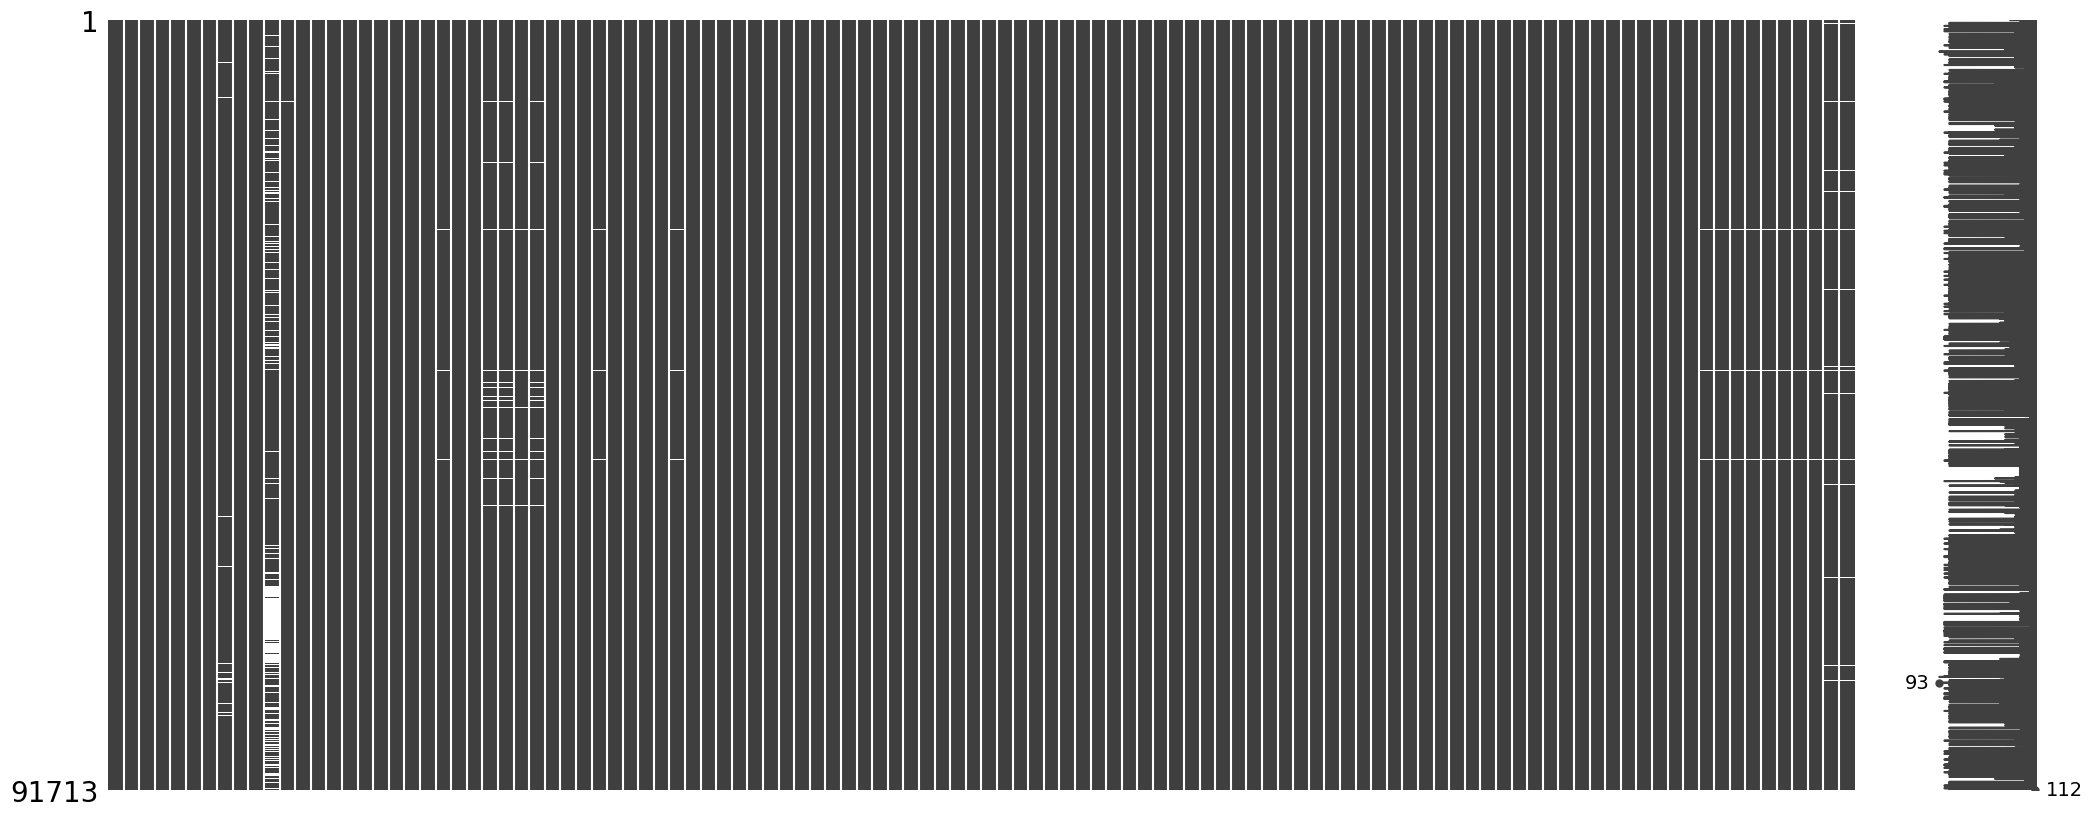

In [49]:
# This part is to check the randomness of the data
import missingno as msno
msno.matrix(df_training)

## Explainability

In [50]:
import shap
shap.initjs()

In [51]:
explainer = shap.TreeExplainer(xgb_weighed)
shap_values = explainer(X_train)

expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

Explainer expected value: -0.0027568209916353226


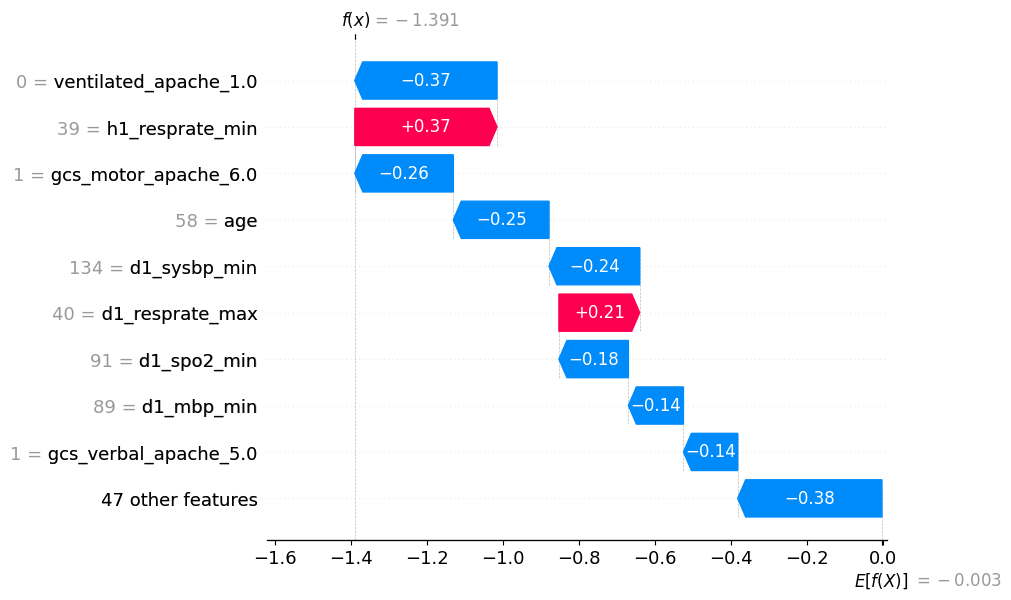

In [52]:
shap.plots.waterfall(shap_values[4481], max_display=10)

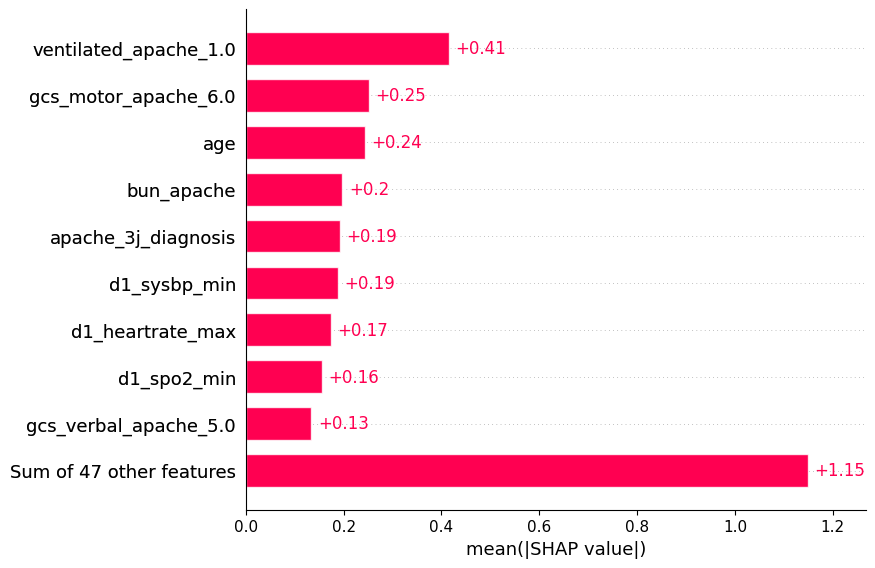

In [53]:
shap.plots.bar(shap_values, max_display=10)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


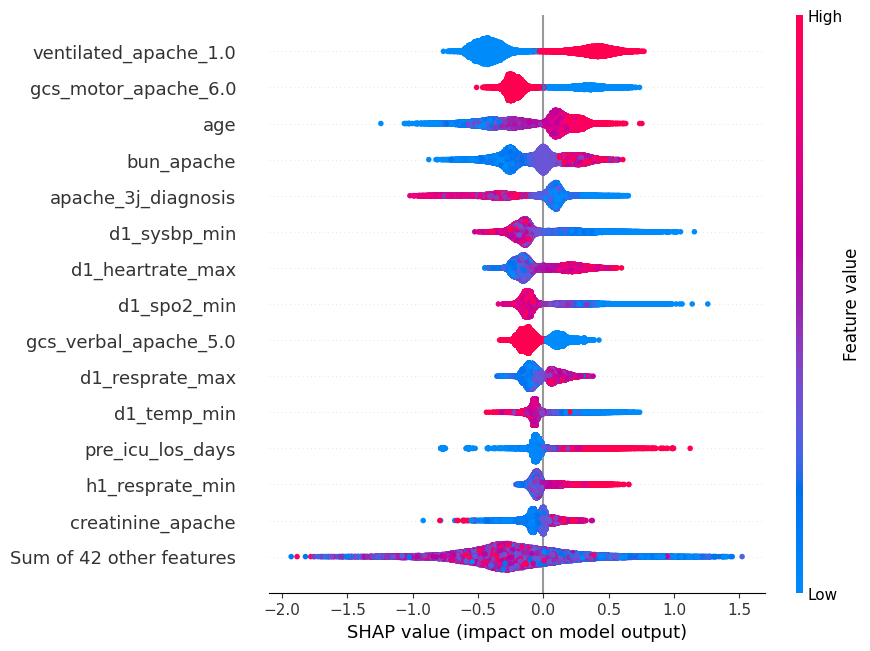

In [54]:
shap.plots.beeswarm(shap_values, max_display=15)